## Quality Detection task

*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

In the field of architecture, the physical environment, materials, and other factors will have an impact on the quality of the project. For example, cracks on the concrete surface can seriously damage the service life of the building. Therefore, engineering quality inspection is very important, among which picture classification is a common technology. Specifically, our task is to give a picture of a specific building material and then to determine whether there are cracks on the surface of the material. The data we use is from the public data set \[1\], which has the following form


<img src="./surface_crack_example.png" width="20%" height="20%" div align=center />

The training set we use specifically includes 1000 pictures as shown in the figure above. In order to test the detection capability of the model, we selected 200 pictures as the test set.

## QNNQD model for crack image detection

### Introduction of QNNQD

QNNQD model is a Quantum Machine Learning (QML) model that can be used for picture classification. We specifically call it a Quantum Neural Network (QNN), which combines Parameterized Quantum Circuit (PQC) and a classical neural network. For surface crack image data, QNNQD can achieve more than 90% classification accuracy. The model is mainly divided into quantum and classical parts. The structure diagram is as follows:

<img src="./qnnqd_model_en.png" width="60%" height="60%"/>


Main process：
- In general, we use principal component analysis (PCA) to reduce the dimension of image data, making it easier to encode classical data into quantum states through encoding circuits.
- The parameterized circuit is used for feature extraction, and its circuit parameters can be adjusted during training. Similar to the trainable parameters in traditional neural networks.
- Quantum measurement, represented by a set of measurement operators, is the process of converting quantum states into classical data, which can be further processed.

## Quick start

### Use the model to make predictions

Entering the command `python qnn_quality_detection.py --config train.toml`  will initiate the model training. Here, we have given a trained model saved in the format `qnnqd.pdparams`, which can be directly used to distinguish surface crack data. One only needs to do the corresponding configuration in this file `test.toml`, and enter the command `python qnn_quality_detection.py --config test.toml` to predict the image. To avoid configuring too many parameters, we provide the `example.toml` file which can be more easily configured. One can execute `python qnn_quality_detection.py --config example.toml` to complete image prediction.

### Online Test

The following shows how to configure the test file `test_toml` to make crack image prediction.

In [1]:
import toml

test_toml = r"""
# The config for test the QNNQD model.
# The path of the input image.
image_path = 'SurfaceCrack/test_data/'

# The number of the data in the test dataset.
# The value defaults to -1 which means using all data.
num_samples = 20

# The path of the trained model, which will be loaded.
model_path = 'qnnqd.pdparams'

# The number of qubits of quantum circuit in each layer.
num_qubits = [4, 4]

# The depth of quantum circuit in each layer.
num_depths = [2, 2]

# The observables of quantum circuit in each layer.
observables = [['Z0', 'Z1', 'Z2', 'Z3'], ['Z0', 'Z1', 'Z2', 'Z3']]
"""

config = toml.loads(test_toml)

In `test_toml` :
- `model_path`: this is the trained model, here we set it as `qnnqd.pdparams`；
- `num_qubits`、`num_depths`、`observables` these parameters correspond to the model ``qnnqd.pdparams`` , `num_qubits = [4,4]` represents the quantum part of a total of two layers of circuit, each layer of the circuit has 4 qubits; `num_depths = [2,2]` represents the depth of parameterized circuit of each layer is 2；`observables` is the specific form of the measurement operator at each layer.

Test:

In [3]:
from paddle_quantum.qml.qnnqd import inference

prediction, prob, label = inference(**config)
print(f"The prediction results of the input images are {str(prediction)[1:-1]} respectively.")
print(f"The labels of the input images are {str(label)[1:-1]} respectively.")

The prediction results of the input images are 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1 respectively.
The labels of the input images are 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1 respectively.


The above is the prediction result of the model for the test set. The prediction details of the two images are given below.

In [4]:
# import
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import numpy as np
import paddle
import matplotlib.pyplot as plt
from paddle_quantum.qml.qnnqd import QNNQD, ImageDataset

# Set model parameters
num_qubits = [4,4]
num_depths = [2,2]
observables = [['Z0','Z1','Z2','Z3'], ['Z0','Z1','Z2','Z3']]

# Load the trained model
model = QNNQD(
    num_qubits=num_qubits,
    num_depths=num_depths,
    observables=observables,
)
state_dict = paddle.load('./qnnqd.pdparams')
model.set_state_dict(state_dict)

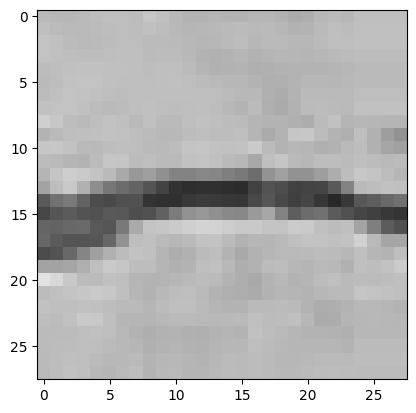

In [5]:
crack_img = plt.imread('positive_crack.jpg') # Positive, label=[1.0,0.0]
plt.imshow(crack_img, cmap='gray', vmin=0, vmax=255)

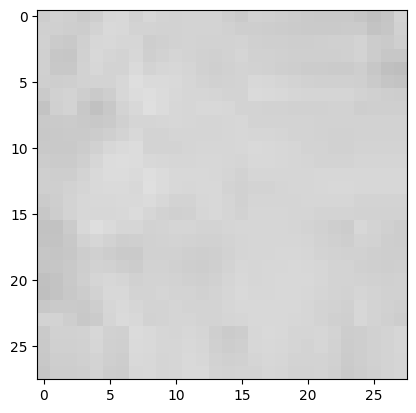

In [6]:
non_crack_img = plt.imread('negative_non_crack.jpg') # Negative, label=[0,1]
plt.imshow(non_crack_img, cmap='gray', vmin=0, vmax=255)

In [7]:
# Encoding images into quantum states
preprocess = ImageDataset(file_path='SurfaceCrack/training_data/', num_samples=500)

crack_img_data = np.reshape(crack_img, 784)
non_crack_img_data = np.reshape(non_crack_img, 784)
test_data = np.array([crack_img_data, non_crack_img_data])

test_data = preprocess.centering.transform(test_data)
test_data = preprocess.pca.transform(test_data)
test_data = preprocess.scaler.transform(test_data)

test_data = paddle.to_tensor(test_data, dtype='float64')

# Use the model to make predictions and get the corresponding probability values
prob = model(test_data)
print(f"For the cracked images, the model has {prob[0][0].item():3.2%} of confidence in detecting their impaired quality.")
print(f"For images without cracks, the model has {prob[1][1].item():3.2%} of confidence to detect the quality without damage.")

For the cracked images, the model has 99.99% of confidence in detecting their impaired quality.
For images without cracks, the model has 77.33% of confidence to detect the quality without damage.


## Remarks

We usually consider adjusting `num_qubits`、`num_depths`、`observables` these three hyperparameters, which have a greater impact on the model.

## References

[1] Özgenel, Çağlar Fırat (2019), “Concrete Crack Images for Classification”, Mendeley Data, V2, doi: 10.17632/5y9wdsg2zt.2 